# Banana Bot
## Samuel Horovatin, 11185403, sch923

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os, datetime
import math
import matplotlib.pyplot as plt

# General Network Constants
EPOCHS = 100
BATCH = 32
OPTIMIZER = tf.keras.optimizers.Adam()

# Data Imports Constants 
DATA_PATH = '.\\data\\bananas\\'
LABEL_PATH = "Estu.csv"
VALIDATION_SPLIT = 0.5
SEED = 1996
HEIGHT_SHIFT = 0.10
WIDTH_SHIFT = 0.10
ZOOM_RANGE  = 0.10 
K_FOLDS = 10
EFF_LVL = 'B0'

# Network Construction Constants
INPUT_SHAPE = {'B0':(224,224,3), 'B1':(240,240,3), 'B2':(260,260,3), 'B3':(300,300,3), 'B4':(380,380,3), 'B5':(456,456,3), 'B6':(528,528,3), 'B7':(600,600,3)} # outlined in keras docs for efficentnet implementation https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
CONV_DEPTH = 256 # Taken from https://github.com/potterhsu/easy-fpn.pytorch. Not 100% sure why it is 256...
TARGET_SIZE = INPUT_SHAPE[EFF_LVL][:2]

def MRD(y_true, y_pred):
    # y_true = tf.cast(y_true,'float32')
    y_pred = y_pred[:, 0] # Uncomment if utilizing Uncertainty_Loss()
    return tf.keras.backend.sum(tf.keras.backend.abs(y_pred - y_true) / y_true )

def One_FVU(y_true, y_pred):
    # y_true = tf.cast(y_true,'float32')
    y_pred = y_pred[:, 0] # Uncomment if utilizing Uncertainty_Loss()
    y_mean = tf.keras.backend.mean(y_true)
    num = tf.math.squared_difference(y_true, y_pred)
    den = tf.keras.backend.sum(y_true - y_mean)
    return 1 - ( num / den )

# As described by Kendall and Gal: https://proceedings.neurips.cc/paper/2017/hash/2650d6089a6d640c5e85b2b88265dc2b-Abstract.html
# For regression, output_D should always be 1
def Uncertainty_Loss(y_true, y_pred):
    y_true = tf.cast(y_true,'float32')
    mu = y_pred[:, 0]
    si = y_pred[:, 1]
    loss = (si + tf.math.squared_difference(y_true, mu) / tf.math.exp(si)) * 0.5
    return tf.reduce_mean(loss)

METRICS = [MRD, One_FVU]

In [2]:
# Gets labels from label csv
data_label_df = pd.read_csv(LABEL_PATH)

# Create training and testing datasets
dat_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=VALIDATION_SPLIT,
    height_shift_range=HEIGHT_SHIFT,
    width_shift_range=WIDTH_SHIFT,
    zoom_range=ZOOM_RANGE,
    fill_mode="wrap"
)

train_datagen = dat_gen.flow_from_dataframe(
    dataframe=data_label_df,
    directory=DATA_PATH,
    x_col='FileName',
    y_col='BananaCount',
    target_size=TARGET_SIZE,
    batch_size=BATCH,
    class_mode='raw',
    shuffle=True,
    seed=SEED,
    subset='training'
)

valid_datagen = dat_gen.flow_from_dataframe(
    dataframe=data_label_df,
    directory=DATA_PATH,
    x_col='FileName',
    y_col='BananaCount',
    target_size=TARGET_SIZE,
    batch_size=BATCH,
    class_mode='raw',
    shuffle=True,
    seed=SEED,
    subset="validation"
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_datagen = test_datagen.flow_from_dataframe(
    dataframe=data_label_df,
    directory=DATA_PATH,
    x_col='FileName',
    y_col='BananaCount',
    target_size=TARGET_SIZE,
    batch_size=BATCH,
    class_mode='raw',
    shuffle=True,
    seed=SEED
)

Found 285 validated image filenames.
Found 284 validated image filenames.
Found 569 validated image filenames.


SHAPE: (32, 224, 224, 3), LABEL: 104


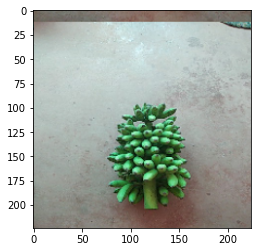

SHAPE: (32, 224, 224, 3), LABEL: 86


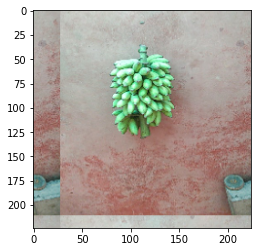

SHAPE: (32, 224, 224, 3), LABEL: 104


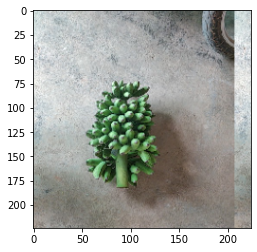

SHAPE: (32, 224, 224, 3), LABEL: 138


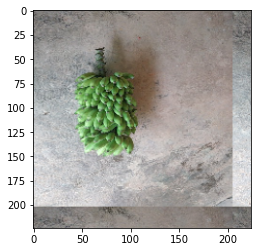

SHAPE: (32, 224, 224, 3), LABEL: 86


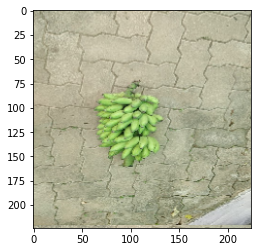

In [3]:
# visualizes images
for _ in range(5):
    img, label = train_datagen.next()
    print(f"SHAPE: {img.shape}, LABEL: {label[0]}")   # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [4]:
# Trains the model given the constant parameters and returns the model and the fit history
def Train_Model(model, train_datagen, test_datagen, valid_datagen, loss_func):
  model.compile(optimizer=OPTIMIZER,
                loss=loss_func,
                metrics=METRICS,
                run_eagerly=True # For debugging
                )

  csv_logger = tf.keras.callbacks.CSVLogger('training.log', separator=',')
  # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.03, mode='min', patience=8)

  STEP_SIZE_TRAIN=train_datagen.n//train_datagen.batch_size
  STEP_SIZE_VALID=valid_datagen.n//valid_datagen.batch_size
  STEP_SIZE_TEST=test_datagen.n//test_datagen.batch_size
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

  history = model.fit(x=train_datagen,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_datagen,
                      validation_steps=STEP_SIZE_VALID, 
                      epochs=EPOCHS,
                      callbacks=[csv_logger, earlystop])
        
  return (model, history)

# Final consolidation layer of FPN predictions
class WeightedAverage(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(WeightedAverage, self).__init__(**kwargs)

    def call(self, model_outputs):
        model_outputs = tf.convert_to_tensor(model_outputs)
        estimates = model_outputs[:, 0]
        variances = model_outputs[:, 1]
        
        weighted_avg = tf.cast(tf.math.reduce_sum(tf.math.divide(estimates, variances)),'float32')

        # based on the wikipedia page for weighted variance average
        avg_variance = tf.cast(tf.math.reduce_mean(variances),'float32')
        return avg_variance * weighted_avg

In [5]:
# Takes in an model and returns a list of edges last layers name in a block
# Layers within blocks need to be named with '*block#*' were # is the block number
def blockEdgeNameFinder(model):
    layer_index = 0 # This allows the function to skip the start of the network
    current_block = "block"
    block_edges = []
    last_layer_name = ""

    for layer in model.layers:
        if current_block in layer.name:
            if layer_index == 0:
                layer_index = layer_index + 1
                current_block = f"block{layer_index}"
                
        elif layer_index == 0:
            continue

        elif "block" in last_layer_name:
            layer_index = layer_index + 1
            next_block = f"block{layer_index}"
            current_block = next_block
            block_edges.append(last_layer_name)
        last_layer_name = layer.name

    return block_edges

# Takes in an model (which is a layer) and a name for the topper and adds the regression topper as described by the paper
def Add_Regression_Top(model, name):
    options = {
        'activation'         : 'relu',
        'kernel_initializer' : tf.keras.initializers.HeNormal()
    }
    outputs = tf.keras.layers.Conv2D(
        256,
        model.shape[1:3],
        activation = options['activation'],
        kernel_initializer= options['kernel_initializer'], 
        name=f'{name}_conv1_256'
    )(model)
    outputs = tf.keras.layers.Conv2D(
        256,
        outputs.shape[1:3],
        activation = options['activation'],
        kernel_initializer= options['kernel_initializer'], 
        name=f'{name}_conv2_256'
    )(outputs)

    outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs)
    outputs = tf.keras.layers.Dense(
        256,
        activation = options['activation'],
        kernel_initializer= options['kernel_initializer'], 
        name=f'{name}_dense_256'
    )(outputs)

    outputs = tf.keras.layers.Dense(
        128,
        activation = options['activation'],
        kernel_initializer= options['kernel_initializer'], 
        name=f'{name}_dense_128'
    )(outputs)

    outputs = tf.keras.layers.Dense(
        64,
        activation = options['activation'],
        kernel_initializer= options['kernel_initializer'], 
        name=f'{name}_dense_64'
    )(outputs)

    # Uncomment if utilizing Uncertainty_Loss() and remove 1 wide dense layer below
    # outputs = tf.keras.layers.Dense(
    #     2, 
    #     kernel_initializer= options['kernel_initializer'],
    #     name=f'{name}_out'
    # )(outputs) 

    outputs = tf.keras.layers.Dense(
        1, 
        kernel_initializer= options['kernel_initializer'],
        name=f'{name}_out'
    )(outputs)
    
    return outputs

In [6]:

def EfficentNet(B_lvl=0):

    if B_lvl == 'B0' or B_lvl == 0:
        basemodel = tf.keras.applications.EfficientNetB0(input_shape=INPUT_SHAPE['B0'], include_top=False, weights='imagenet')
    elif B_lvl == 'B1' or B_lvl == 1:
        basemodel = tf.keras.applications.EfficientNetB1(input_shape=INPUT_SHAPE['B1'], include_top=False, weights='imagenet')
    elif B_lvl == 'B2' or B_lvl == 2:
        basemodel = tf.keras.applications.EfficientNetB2(input_shape=INPUT_SHAPE['B2'], include_top=False, weights='imagenet')
    elif B_lvl == 'B3' or B_lvl == 3:
        basemodel = tf.keras.applications.EfficientNetB3(input_shape=INPUT_SHAPE['B3'], include_top=False, weights='imagenet')
    elif B_lvl == 'B4' or B_lvl == 4:
        basemodel = tf.keras.applications.EfficientNetB4(input_shape=INPUT_SHAPE['B4'], include_top=False, weights='imagenet')
    elif B_lvl == 'B5' or B_lvl == 5:
        basemodel = tf.keras.applications.EfficientNetB5(input_shape=INPUT_SHAPE['B5'], include_top=False, weights='imagenet')
    elif B_lvl == 'B6' or B_lvl == 6:
        basemodel = tf.keras.applications.EfficientNetB6(input_shape=INPUT_SHAPE['B6'], include_top=False, weights='imagenet')
    elif B_lvl == 'B7' or B_lvl == 7:
        basemodel = tf.keras.applications.EfficientNetB7(input_shape=INPUT_SHAPE['B7'], include_top=False, weights='imagenet')   
    else:
        print(f"EfficentNet Error: Unknown efficentnet level {B_lvl}, using EfficientNetB0 as defualt")
        basemodel = tf.keras.applications.EfficientNetB0(input_shape=INPUT_SHAPE['B0'], include_top=False, weights='imagenet')
    # basemodel.summary()
    return build_EfficentNet(basemodel)

def build_EfficentNet(basemodel):
    FPN_LAYER_NAMES = blockEdgeNameFinder(basemodel)
    backbone = []

    FPN_LAYER_NAMES = FPN_LAYER_NAMES[2:]
    FPN_LAYER_NAMES = FPN_LAYER_NAMES[::-1] 

    for name in FPN_LAYER_NAMES: 
        backbone.append(basemodel.get_layer(name).output)

    prediction_outputs = [] 
    first_layer = True
    layer_index = 7
    
    for layer in backbone: 
        # FPN consolidation
        FPN_layer = tf.keras.layers.Conv2D(filters=CONV_DEPTH, kernel_size=(1,1), name=f"fpn{layer_index}_conv")(layer) 
        if not first_layer:
            last_shape = last_FPN_layer.shape[1:][1]
            current_shape = FPN_layer.shape[1:][1] # All layers should be square resolution
            scale = int(round(current_shape/last_shape))
            if scale != 1:
                last_FPN_layer = tf.keras.layers.UpSampling2D((scale,scale), name=f"fpn{layer_index}_scale{scale}")(last_FPN_layer)
            
            # Fixes non-int scaling between layers via zero padding
            if current_shape % last_shape != 0:
                scale = int(abs(FPN_layer.shape[1:][1] - last_FPN_layer.shape[1:][1]))
                print(f"FPN_layer.shape {FPN_layer.shape[1:][1]}, last_FPN_layer.shape {last_FPN_layer.shape[1:][1]}, scale {scale}")
                FPN_layer = tf.keras.layers.ZeroPadding2D(padding=scale, name=f"fpn{layer_index}_zero_pad{scale}")(FPN_layer)
                print(f"FPN_layer.shape {FPN_layer.shape[1:][1]}, last_FPN_layer.shape {last_FPN_layer.shape[1:][1]}, scale {scale}")
            
        else:
            first_layer = False

        last_FPN_layer = FPN_layer
        new_prediction = Add_Regression_Top(FPN_layer, f"fpn_reg{layer_index}")
        prediction_outputs.append(new_prediction)

        layer_index = layer_index - 1
    final_model = tf.keras.models.Model(inputs=basemodel.inputs, outputs=prediction_outputs, name="EfficentNet_FPN")
    return final_model
    
rebuilt_model = EfficentNet(EFF_LVL)
rebuilt_model.summary()

Model: "EfficentNet_FPN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________________________________________________________________________

In [7]:
loss_func = tf.keras.losses.MSE
(model, history) = Train_Model(rebuilt_model, train_datagen, test_datagen, valid_datagen, loss_func)

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 238771.7188 - fpn_reg7_out_loss: 4578.7222 - fpn_reg6_out_loss: 4397.5845 - fpn_reg5_out_loss: 4051.7974 - fpn_reg4_out_loss: 10631.7090 - fpn_reg3_out_loss: 215111.8750 - fpn_reg7_out_MRD: 548.7626 - fpn_reg7_out_One_FVU: -inf - fpn_reg6_out_MRD: 508.1946 - fpn_reg6_out_One_FVU: -inf - fpn_reg5_out_MRD: 476.7711 - fpn_reg5_out_One_FVU: -inf - fpn_reg4_out_MRD: 602.6723 - fpn_reg4_out_One_FVU: -inf - fpn_reg3_out_MRD: 2233.0789 - fpn_reg3_out_One_FVU: -inf

KeyboardInterrupt: 